In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

SUPERRESOLUCIÓN DE 7X7

In [2]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
class Autoencoder_SuperResolution_7x7(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> N, 64, 4, 4
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1), # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
def downsample_images(images, target_size=7):
    return F.interpolate(images, size=target_size, mode='bilinear')

In [5]:
model = Autoencoder_SuperResolution_7x7().to(device)
criterion = nn.MSELoss()

INPUT_SIZE = 7
num_epochs = 100
initial_lr = 5e-4
LR_CHANGE_EPOCH = 60

optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-5)
outputs = []

print(f"\nIniciando entrenamiento para Superresolución (Entrada: {INPUT_SIZE}x{INPUT_SIZE}, Salida: 28x28)")


for epoch in range(num_epochs):


    if epoch == LR_CHANGE_EPOCH:
        new_lr = 1e-5
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

    for (img_hr, _) in train_loader:
        img_hr = img_hr.to(device)
        img = downsample_images(img_hr, INPUT_SIZE)
        recon = model(img)
        loss = criterion(recon, img_hr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1:02d}, Loss:{loss.item():.6f}')
    outputs.append((epoch, img_hr.cpu().detach(), img.cpu().detach(), recon.cpu().detach()))

print("Entrenamiento finalizado.")


Iniciando entrenamiento para Superresolución (Entrada: 7x7, Salida: 28x28)
Epoch:01, Loss:0.014616
Epoch:02, Loss:0.012412
Epoch:03, Loss:0.011194
Epoch:04, Loss:0.011608
Epoch:05, Loss:0.011273
Epoch:06, Loss:0.009040
Epoch:07, Loss:0.011127
Epoch:08, Loss:0.009298
Epoch:09, Loss:0.010909
Epoch:10, Loss:0.010958
Epoch:11, Loss:0.008726
Epoch:12, Loss:0.011081
Epoch:13, Loss:0.009188
Epoch:14, Loss:0.009874
Epoch:15, Loss:0.011815
Epoch:16, Loss:0.008594
Epoch:17, Loss:0.009919
Epoch:18, Loss:0.009741
Epoch:19, Loss:0.011731
Epoch:20, Loss:0.011157
Epoch:21, Loss:0.008981
Epoch:22, Loss:0.010298
Epoch:23, Loss:0.010699
Epoch:24, Loss:0.008185
Epoch:25, Loss:0.009724
Epoch:26, Loss:0.009851
Epoch:27, Loss:0.009134
Epoch:28, Loss:0.008535
Epoch:29, Loss:0.008922
Epoch:30, Loss:0.009650
Epoch:31, Loss:0.009730
Epoch:32, Loss:0.009401
Epoch:33, Loss:0.007975
Epoch:34, Loss:0.008680
Epoch:35, Loss:0.008961
Epoch:36, Loss:0.008217
Epoch:37, Loss:0.008722
Epoch:38, Loss:0.009471
Epoch:39, Lo

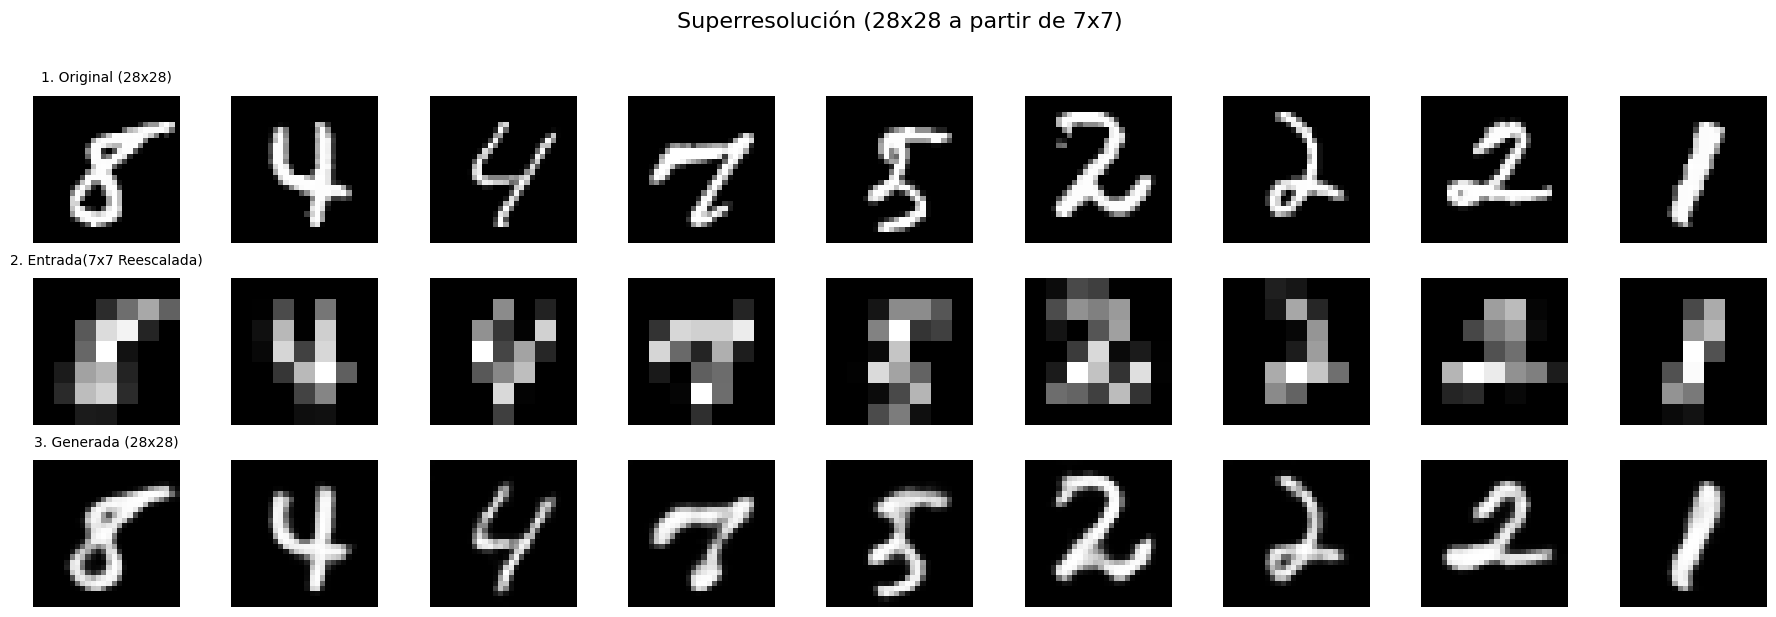

In [6]:
model.eval()
dataiter_valid = iter(valid_loader)
images_valid, _ = next(dataiter_valid)

images_hr_sample = images_valid[:9].to(device)
images_lr_sample = downsample_images(images_hr_sample, INPUT_SIZE)

with torch.no_grad():
    images_sr_sample = model(images_lr_sample)

images_hr_np = images_hr_sample.cpu().numpy()
images_lr_np = images_lr_sample.cpu().numpy()
images_sr_np = images_sr_sample.cpu().numpy()

num_images = 9
plt.figure(figsize=(num_images * 2, 6))
plt.gray()

row_titles = ["1. Original (28x28)", f"2. Entrada({INPUT_SIZE}x{INPUT_SIZE} Reescalada)", "3. Generada (28x28)"]

for i in range(num_images):
    # Fila 1: Imágenes Originales
    plt.subplot(3, num_images, i + 1)
    if i == 0: plt.title(row_titles[0], fontsize=10, pad=10)
    plt.imshow(images_hr_np[i, 0])
    plt.axis('off')

    # Fila 2: Imágenes de 7x7
    plt.subplot(3, num_images, num_images + i + 1)
    img_upscale = F.interpolate(torch.tensor(images_lr_np[i]).unsqueeze(0), size=28, mode='nearest').squeeze().numpy()
    if i == 0: plt.title(row_titles[1], fontsize=10, pad=10)
    plt.imshow(img_upscale)
    plt.axis('off')

    # Fila 3: Imágenes Reconstruidas
    plt.subplot(3, num_images, 2 * num_images + i + 1)
    if i == 0: plt.title(row_titles[2], fontsize=10, pad=10)
    plt.imshow(images_sr_np[i, 0])
    plt.axis('off')

plt.suptitle(f"Superresolución (28x28 a partir de {INPUT_SIZE}x{INPUT_SIZE})", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

SUPERRESOLUCIÓN 14X14


In [29]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [30]:
class Autoencoder_SuperResolution_14x14(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1), # -> N, 32, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> N, 64, 7, 7
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # -> N, 32, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), # -> N, 16, 28, 28
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, stride=1, padding=1), # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [31]:
def downsample_images(images, target_size=14):
    return F.interpolate(images, size=target_size, mode='bilinear')

In [32]:
model = Autoencoder_SuperResolution_14x14().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 15
outputs = []

print("\nIniciando entrenamiento para Superresolución (Entrada: 14x14, Salida: 28x28)...")
for epoch in range(num_epochs):
    for (img_hr, _) in train_loader:
        img_hr = img_hr.to(device)
        img = downsample_images(img_hr, 14)
        recon = model(img)
        loss = criterion(recon, img_hr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1:02d}, Loss:{loss.item():.6f}')
    outputs.append((epoch, img_hr.cpu().detach(), img.cpu().detach(), recon.cpu().detach()))

print("Entrenamiento finalizado.")


Iniciando entrenamiento para Superresolución (Entrada: 14x14, Salida: 28x28)...
Epoch:01, Loss:0.108417
Epoch:02, Loss:0.102592
Epoch:03, Loss:0.116645
Epoch:04, Loss:0.110554
Epoch:05, Loss:0.111633
Epoch:06, Loss:0.112053
Epoch:07, Loss:0.116605
Epoch:08, Loss:0.015392
Epoch:09, Loss:0.002540
Epoch:10, Loss:0.001787
Epoch:11, Loss:0.002057
Epoch:12, Loss:0.001612
Epoch:13, Loss:0.001799
Epoch:14, Loss:0.001657
Epoch:15, Loss:0.001519
Entrenamiento finalizado.


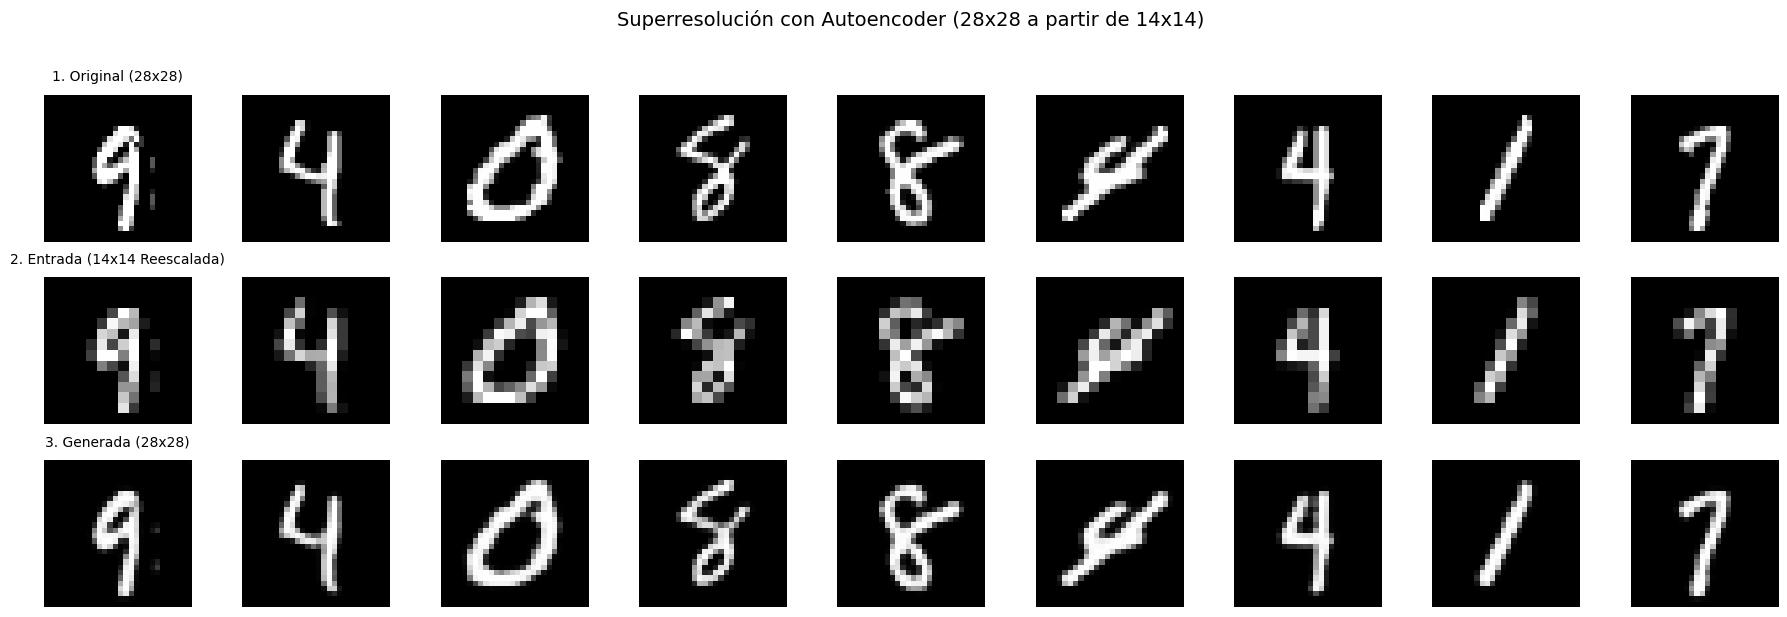

In [33]:
model.eval()
dataiter_valid = iter(valid_loader)
images_valid, _ = next(dataiter_valid)

images_hr_sample = images_valid[:9].to(device)
images_lr_sample = downsample_images(images_hr_sample, 14)

with torch.no_grad():
    images_sr_sample = model(images_lr_sample)

images_hr_np = images_hr_sample.cpu().numpy()
images_lr_np = images_lr_sample.cpu().numpy()
images_sr_np = images_sr_sample.cpu().numpy()

num_images = 9
plt.figure(figsize=(num_images * 2, 6))
plt.gray()

row_titles = ["1. Original (28x28)", "2. Entrada (14x14 Reescalada)", "3. Generada (28x28)"]

for i in range(num_images):
    # Fila 1: Imágenes Originales
    plt.subplot(3, num_images, i + 1)
    if i == 0: plt.title(row_titles[0], fontsize=10, pad=10)
    plt.imshow(images_hr_np[i, 0])
    plt.axis('off')

    # Fila 2: Imágenes de Baja Resolución
    plt.subplot(3, num_images, num_images + i + 1)
    img_upscale = F.interpolate(torch.tensor(images_lr_np[i]).unsqueeze(0), size=28, mode='nearest').squeeze().numpy()
    if i == 0: plt.title(row_titles[1], fontsize=10, pad=10)
    plt.imshow(img_upscale)
    plt.axis('off')

    # Fila 3: Imágenes Reconstruidas
    plt.subplot(3, num_images, 2 * num_images + i + 1)
    if i == 0: plt.title(row_titles[2], fontsize=10, pad=10)
    plt.imshow(images_sr_np[i, 0])
    plt.axis('off')

plt.suptitle("Superresolución con Autoencoder (28x28 a partir de 14x14)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()